In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import galsim
from galsim.angle import radians, arcsec, degrees, AngleUnit
import numpy as np
import matplotlib.pylab as plt
import time
import sys

sys.path.append('/Users/andypark/Desktop/phd/batsim/src')
import batsim.pltutil as batplot

from astropy import wcs
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename

import fpfs

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

In [2]:
wcsfile = "./eimage_00449053-0-r-R03_S02-det020.fits"
f = fits.open(wcsfile)
w = WCS(f[0].header)
#w.wcs.cd *= 1. * arcsec / degrees
#w.sip.a[1, 0] += 1.
#w.sip.b[0, 1] += 1.

2023/10/20 14:11:37 ---  FITSFixedWarning: 'datfix' made the change 'Set DATE-OBS to '2025-12-08T01:04:57.498' from MJD-OBS'.


In [3]:
wcs_g = galsim.GSFitsWCS(wcsfile)
skypos = wcs_g.toWorld(galsim.PositionI(0, 0))
skypos.ra.deg, skypos.dec.deg

(54.494749102342645, -33.899898366804834)

Let $x, y$ be the relative pixel coordinates with origin at $\mathrm{CRPIX1}$ and $\mathrm{CRPIX2}$ and $u, v$ be the coordinates on the tangent plane of the celestial sphere
$$
\begin{pmatrix}u \\ v\end{pmatrix} = \begin{pmatrix}\mathrm{CD1\_1} & \mathrm{CD1\_1} \\ \mathrm{CD2\_1} & \mathrm{CD2\_2}\end{pmatrix}\begin{pmatrix}x + f(x, y) \\ y + g(x, y)\end{pmatrix}$$

The distortion matrix can be written as
$$
\begin{pmatrix}du \\ dv\end{pmatrix} = \begin{pmatrix}\partial_x u & \partial_y u \\ \partial_x v & \partial_y v\end{pmatrix}\begin{pmatrix}dx \\ dy\end{pmatrix} = M\begin{pmatrix}1 - g_1 & -g_2 + \theta \\ -g_2-\theta & 1+g_1\end{pmatrix}\begin{pmatrix}dx \\ dy\end{pmatrix}$$

and Field-Distortion Shear as
$$g_1(\mathrm{FD}) = (\partial_y v - \partial_x u) / (\partial_y v + \partial_x u)$$ and 
$$g_2(\mathrm{FD}) = -(\partial_x v - \partial_y u) / (\partial_y v + \partial_x u)$$

In [4]:
def get_radec(params, w, deg=False):
    params = jnp.asarray(params)
    params = params.astype(jnp.float64)
    u, v = get_uv(params, w)
    # 4) turn u, v into ra, dec
    cra, cdec = w.wcs.crval * degrees
    cra = cra.rad
    cdec = cdec.rad
    #u = u * radians / degrees
    #v = v * radians / degrees
    #https://github.com/LSSTDESC/Coord/blob/fdb834dbb0d5fe8ef8da97ba54343aca94e7030f/coord/celestial.py#L738
    rsq = u * u
    rsq += v * v
    cosc = sinc_over_r = 1./jnp.sqrt(1.+rsq)
    sindec = v * sinc_over_r
    sindec *= jnp.cos(cdec)
    sindec += cosc * jnp.sin(cdec)
    tandra_num = u * sinc_over_r
    tandra_num *= -1.
    tandra_denom = v * sinc_over_r
    tandra_denom *= -jnp.sin(cdec)
    tandra_denom += cosc * jnp.cos(cdec)
    dec = jnp.arcsin(sindec)
    ra = cra + jnp.arctan2(tandra_num, tandra_denom)
    #center = galsim.CelestialCoord(w.wcs.crval[0] * degrees, w.wcs.crval[1] * degrees)
    #ra, dec = center.deproject_rad(u, v, "gnomonic")
    if deg:
        return ra * 180. / jnp.pi, dec * 180. / jnp.pi
    return ra, dec

In [5]:
def get_uv(params, w):
    params = jnp.asarray(params).astype(jnp.float32)
    x, y = params
    x -= w.wcs.crpix[0]
    y -= w.wcs.crpix[1] 

    ab = np.array([w.sip.a, w.sip.b])
    order = len(ab[0])-1
    xpow = x ** jnp.arange(order+1)
    ypow = y ** jnp.arange(order+1)
    p1 = jnp.dot(jnp.dot(ab, ypow), xpow)
    
    x += p1[0]
    y += p1[1]
    
    u, v = w.wcs.cd @ jnp.array([x, y])
    factor = 1. * degrees / radians
    u *= -factor
    v *= factor
    
    return jnp.array([u, v])
    #return u, v

In [6]:
# To get the field distortion shear field from the wcs
if not os.path.exists("./g1_fd.fits") and not os.path.exists("./g2_fd.fits"):
    jac = np.vectorize(wcs_g.local)
    pos = np.array([galsim.PositionI(i, j) for i in range(4072) for j in range(4000)])
    jac_pos = jac(pos)
    
    def get_shear(jac):
        g1_fd = (jac.dvdy - jac.dudx) / (jac.dvdy + jac.dudx)
        g2_fd = -(jac.dvdx + jac.dudy) / (jac.dvdy + jac.dudx)
        return g1_fd, g2_fd
        
    g1_fd, g2_fd = np.vectorize(get_shear)(jac_pos)
else:
    g1_fd = fits.open("./g1_fd.fits")[0].data
    g2_fd = fits.open("./g2_fd.fits")[0].data

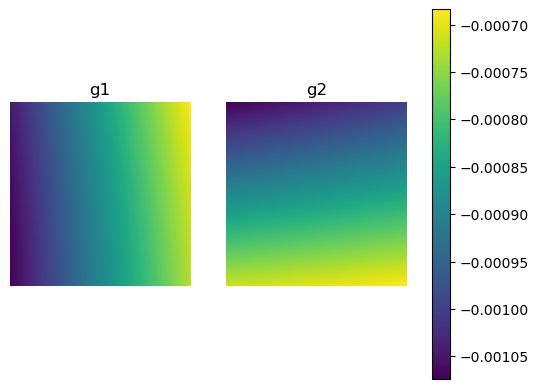

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2)
g_fd = np.array([g1_fd, g2_fd])
for i, ax in enumerate(axes.flat):
    im = ax.imshow(g_fd[i], origin='lower')
    ax.axis(False)
    ax.set_title(f"g{i+1}")

fig.colorbar(im, ax=axes.ravel().tolist())

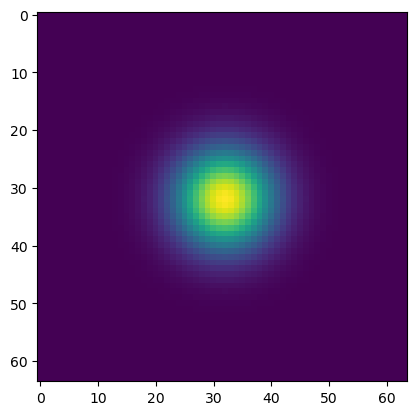

In [8]:
sersic_gal = galsim.Sersic(n=0.5, half_light_radius=1.4, flux=40)
img = sersic_gal.drawImage(nx=64, ny=64, wcs=wcs_g, center=(32, 32), method="sb")
plt.imshow(img.array)

In [9]:
nn = 64
shape = (nn, nn)
scale = 0.2
psf_array = np.zeros(shape)
psf_array[nn // 2, nn // 2] = 1
center_xy = np.array([nn//2+1, nn//2+1])

fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.53)
mms =  fpTask.measure(img.array, center_xy)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=20)
resp1=np.average(ells['fpfs_R1E'])
shear1=np.average(ells['fpfs_e1'])/resp1
resp2=np.average(ells['fpfs_R2E'])
shear2=np.average(ells['fpfs_e2'])/resp2

print("measured shear1: %.7f" % shear1)
print("measured shear2: %.7f" % shear2)

2023/10/20 14:11:38 ---  Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/10/20 14:11:38 ---  Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/10/20 14:11:38 ---  Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/andypark/miniconda3/envs/batsim/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2023/10/20 14:11:38 ---  Order of the shear estimator: nnord=4
2023/10/20 14:11:38 ---  Shapelet kernel in configuration space: sigma= 0.5300 arcsec
2023/10/20 14:11:38 ---  Detection kernel in configuration space: sigma= 0.5300 arcsec


measured shear1: -0.0008989
measured shear2: -0.0010856


In [10]:
# Field distortion at the center of galaxy
g1_fd[32, 32], g2_fd[32, 32]

(-0.0013430572112116033, -0.0007178825540912163)